# Assignment 4 - Website WordClouds

## Overview

This notebook implements a web crawler that generates word clouds from website content. The system crawls a target website, extracts meaningful text, and creates visual representations of word frequencies.

---

## Configuration Parameters

```python
START_URL   = "https://www.bbc.com/"  # Target website
MAX_PAGES   = 20                       # Maximum pages to collect
MIN_WORDS   = 500                      # Minimum word count per page
DELAY       = 0.5                      # Delay between requests (seconds)
OUT_DIR     = "out_crawl"             # Output directory
```

---

## Import Libraries

This section imports all necessary dependencies:

- **Web Scraping**: `requests`, `BeautifulSoup`, `readability-lxml`
- **Text Processing**: `nltk` for tokenization and stopwords
- **Visualization**: `wordcloud` and `matplotlib`
- **Data Handling**: `pandas` for CSV generation

**Note**: If you encounter matplotlib import errors, reinstall with:
```bash
pip install --upgrade matplotlib wordcloud
```

---

In [ ]:
# Import core system and utility modules
import os, re, time, hashlib, html as ihtml, unicodedata
from urllib.parse import urljoin, urlparse, urldefrag   # To resolve relative/absolute links

# Web-related modules
import requests                      # For sending HTTP GET requests
from bs4 import BeautifulSoup         # For parsing HTML content
from readability import Document      # For extracting the readable part of a webpage
import pandas as pd                   # For building and saving tables (CSV)

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

# Visualization
from wordcloud import WordCloud       # Generates word cloud images
import matplotlib.pyplot as plt       # For plotting and saving images

# Make sure NLTK stopwords are available (download once if missing)
try:
    _ = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")



In [6]:
# ---------- USER CONFIGURATION ----------
START_URL = "https://www.bbc.com/"   # The site to start crawling
MAX_PAGES = 20                        # Maximum number of pages to visit
MIN_WORDS = 500                       # Minimum words required for a page to be analyzed
DELAY = 0.5                           # Seconds to wait between requests (politeness)
OUT_DIR = "out_crawl"                 # Folder to store outputs
# ---------------------------------------

# Load English stopwords once (common words like "the", "is", etc.)
EN_STOP = set(stopwords.words("english"))

# Custom HTTP header to identify your crawler politely
HEADERS = {"User-Agent": "NLP-Assignment-Wordcloud/1.0 (+https://example.edu)"}

# Ensure the output folders exist
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(f"{OUT_DIR}/wordclouds", exist_ok=True)


## Helper Functions

### URL Management Functions

**`normalize_url(u)`**
- Removes URL fragments (#) and query parameters (?)
- Ensures consistent URL comparison

**`same_site(base, other)`**
- Checks if two URLs belong to the same domain
- Extracts and compares the base domain (e.g., "bbc.com")

### Web Scraping Functions

**`fetch(url)`**
- Downloads HTML content from a URL
- Handles errors gracefully with timeouts
- Only accepts successful HTML responses (status 200)

**`extract_links(base, html_text)`**
- Finds all `<a>` tags with href attributes
- Converts relative URLs to absolute URLs
- Filters to only same-site links

In [7]:
def normalize_url(u):
    # Remove URL fragments (#...) and query strings (?x=y) to prevent duplicates
    return urldefrag(u)[0].split("?")[0]

def same_site(base, other):
    # Extract the main domain (eTLD+1) for comparison
    def domain(u): return ".".join(urlparse(u).netloc.split(".")[-2:])
    # Return True if both URLs share the same domain
    return domain(base) == domain(other)

def fetch(url):
    # Print the URL being fetched
    print(f"[FETCH] {url}")
    try:
        # Send a GET request with timeout and custom header
        r = requests.get(url, timeout=15, headers=HEADERS)

        # Only process valid HTML pages with status code 200
        if "text/html" in r.headers.get("Content-Type", "") and r.status_code == 200:
            print(f"  -> Status: {r.status_code}, OK")
            return r.text   # Return the HTML source
        else:
            print(f"  -> Skipped (non-HTML or bad status: {r.status_code})")
    except requests.RequestException as e:
        # Handle network errors or timeouts gracefully
        print(f"  -> ERROR fetching {url}: {e}")
    return None

def extract_links(base, html_text):
    # Parse the HTML to find all anchor tags <a href="...">
    soup = BeautifulSoup(html_text, "html.parser")
    out = set()  # Use a set to avoid duplicate links

    for a in soup.find_all("a", href=True):
        link = urljoin(base, a["href"])    # Resolve relative URLs
        link = normalize_url(link)         # Clean link from fragments/queries
        # Only keep HTTP links from the same domain
        if link.startswith("http") and same_site(base, link):
            out.add(link)

    print(f"  -> Found {len(out)} links on this page")
    return out

### Text Processing Functions

**`clean_text(html_text)`**
- Uses readability library to extract main content
- Falls back to basic text extraction if needed
- Removes extra whitespace and HTML entities

**`extract_title(html_text, url)`**
- Tries multiple methods to find article title:
  1. OpenGraph meta tags (`og:title`)
  2. HTML `<title>` tag
  3. First `<h1>` heading
  4. URL path as fallback

**`word_count(text)`**
- Counts tokens containing alphabetic characters
- Excludes numbers and punctuation-only tokens

**`tokenize(text)`**
- Converts text to lowercase tokens
- Filters out:
  - Stopwords (common words like "the", "is", "and")
  - Words shorter than 3 characters
  - Non-alphabetic tokens
  - Punctuation

In [ ]:
def clean_text(html_text):
    # Extract main readable text using Readability algorithm if possible
    try:
        doc = Document(html_text)
        # Parse only the main content summary
        soup = BeautifulSoup(doc.summary(html_partial=True), "html.parser")
        text = soup.get_text(" ")
    except Exception:
        # Fallback: extract all visible text from raw HTML
        soup = BeautifulSoup(html_text, "html.parser")
        text = soup.get_text(" ")

    # Replace multiple spaces/newlines with a single space and unescape HTML entities
    return re.sub(r"\s+", " ", ihtml.unescape(text)).strip()


def extract_title(html_text, url=""):
    # Attempt to extract a meaningful title for the article/page
    soup = BeautifulSoup(html_text, "html.parser")

    # 1: Prefer Open Graph title if available
    og = soup.find("meta", property="og:title")
    if og and og.get("content"):
        return og["content"].strip()

    # 2: Fallback to <title> tag, removing site suffixes like "| BBC News"
    if soup.title and soup.title.string:
        t = soup.title.string.strip()
        parts = re.split(r"\s+[\|\-–—]\s+", t)
        if len(parts) > 1:
            return parts[0].strip()
        return t

    # 3: Try the first <h1> element on the page
    h1 = soup.find("h1")
    if h1 and h1.get_text(strip=True):
        return h1.get_text(strip=True)

    # 4: Final fallback: use the URL path as title
    return url.rsplit("/", 1)[-1] or url

def word_count(text):
    # Count how many alphabetic tokens are present in the text
    return len([t for t in wordpunct_tokenize(text) if re.search(r"[A-Za-z]", t)])

def tokenize(text):
    # Tokenize text and keep only meaningful lowercase words
    tokens = wordpunct_tokenize(text)
    words = []

    for t in tokens:
        t = t.lower()  # normalize to lowercase
        # Accept only alphabetic tokens (ignore numbers, punctuation)
        if not re.match(r"^[a-z][a-z\-']+$", t):
            continue
        # Skip stopwords and very short words (<3 chars)
        if t in EN_STOP or len(t) < 3:
            continue
        words.append(t)
    return words

### Output Functions

**`slugify(s, max_len=60)`**
- Converts titles to safe filenames
- Removes special characters and accents
- Replaces spaces with hyphens

**`save_wordcloud(words, path)`**
- Generates word cloud visualization (1200×800 pixels)
- Larger words indicate higher frequency
- Saves as PNG file with 160 DPI

In [9]:
def slugify(s, max_len=60):
    # Normalize string for filenames: remove accents and special chars
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("ascii")    # remove non-ASCII chars
    s = re.sub(r"[^A-Za-z0-9]+", "-", s).strip("-").lower()  # keep alphanumeric and hyphens
    if not s:
        s = "page"
    return s[:max_len]  # truncate to avoid overly long filenames

def save_wordcloud(words, path):
    # Skip if no words were provided
    if not words:
        return

    # Combine all words into a single string separated by spaces
    txt = " ".join(words)

    # Configure word cloud: white background, ignore collocations (word pairs)
    wc = WordCloud(width=1200, height=800, background_color="white",
                   stopwords=EN_STOP, collocations=False)

    # Generate and display the word cloud
    plt.figure(figsize=(12, 8))
    plt.imshow(wc.generate(txt))
    plt.axis("off")           # hide axes
    plt.tight_layout(pad=0)   # remove borders around the image
    plt.savefig(path, dpi=160)
    plt.close()               # close the figure to save memory
    print(f"[WORDCLOUD SAVED] {path}")


## Web Crawling Algorithm

The `crawl()` function implements a **breadth-first search** crawler:

In [10]:
def crawl(start_url):
    # Initialize sets/lists for visited URLs and queue
    seen = set()          # URLs already visited
    queue = [start_url]   # URLs waiting to be visited
    pages = []            # Valid pages (URL, title, text)

    print(f"\n=== STARTING CRAWL ===\nBase URL: {start_url}\n")

    # Continue crawling until queue is empty or MAX_PAGES reached
    while queue and len(pages) < MAX_PAGES:
        url = queue.pop(0)      # Take the first URL in queue
        if url in seen:         # Skip duplicates
            continue
        seen.add(url)

        html = fetch(url)       # Download page HTML
        if not html:
            continue

        title = extract_title(html, url)  # Extract readable title
        text = clean_text(html)           # Extract main text
        wc = word_count(text)             # Count words

        print(f"  -> Title: {title}")
        print(f"  -> Word count: {wc}")

        # Accept only pages with enough content
        if wc >= MIN_WORDS:
            pages.append((url, title, text))
            print(f"[ACCEPTED] {url} ({wc} words)")
        else:
            print(f"[SKIPPED] {url} (too short: {wc} words)")

        # Collect more internal links for crawling
        for link in extract_links(url, html):
            if link not in seen:
                queue.append(link)

        # Wait between requests to respect servers
        time.sleep(DELAY)
        print(f"  -> Queue size: {len(queue)} | Pages collected: {len(pages)}\n")

    print(f"\n=== CRAWL COMPLETE === Collected {len(pages)} valid pages.\n")
    return pages


### Process Flow:

1. **Initialize** with starting URL in queue
2. **Fetch** page from front of queue
3. **Extract** title and clean text content
4. **Validate** page has minimum word count (500+)
5. **Accept** or reject page based on validation
6. **Discover** new links and add to queue
7. **Repeat** until MAX_PAGES collected or queue empty

In [11]:
def build_outputs(pages):
    print("\n=== GENERATING WORDCLOUDS & SUMMARY ===")

    # Make sure output folders exist
    os.makedirs(OUT_DIR, exist_ok=True)
    os.makedirs(f"{OUT_DIR}/wordclouds", exist_ok=True)

    rows = []  # store metadata for each page

    for i, (src, title, text) in enumerate(pages, 1):
        print(f"[PROCESS] ({i}/{len(pages)}) {title}  —  {src}")

        # Tokenize text and compute frequency counts
        words = tokenize(text)
        top = ", ".join(pd.Series(words).value_counts().head(15).index)

        # Generate unique, clean image filename
        base = slugify(title)
        h = hashlib.md5(src.encode()).hexdigest()[:8]   # short hash of URL
        img_rel = f"wordclouds/wc_{base}_{h}.png"       # relative path
        img_abs = f"{OUT_DIR}/{img_rel}"                # absolute path

        # Create and save the word cloud image
        save_wordcloud(words, img_abs)

        # Append metadata to the list
        rows.append({
            "title": title,
            "source": src,
            "words": word_count(text),
            "top_keywords": top,
            "image": img_rel
        })

    # Convert all rows to a pandas DataFrame and save as CSV
    df = pd.DataFrame(rows)
    df.to_csv(f"{OUT_DIR}/index.csv", index=False)

    print(f"\n[SUMMARY SAVED] {OUT_DIR}/index.csv ({len(df)} entries)")
    print(f"[DONE] All outputs are in '{OUT_DIR}' folder.\n")


In [12]:
# Print current settings
print("========== WORDCLOUD GENERATOR ==========")
print(f"Target: {START_URL}")
print(f"Max pages: {MAX_PAGES}, Min words: {MIN_WORDS}, Delay: {DELAY}s\n")

# Start crawling from START_URL
pages = crawl(START_URL)

# If pages were found, generate outputs
if not pages:
    print("No pages found. Try another URL or lower MIN_WORDS.")
else:
    build_outputs(pages)


========== WORDCLOUD GENERATOR ==========
Target: https://www.bbc.com/
Max pages: 20, Min words: 500, Delay: 0.5s


=== STARTING CRAWL ===
Base URL: https://www.bbc.com/

[FETCH] https://www.bbc.com/
  -> Status: 200, OK
  -> Title: BBC Home - Breaking News, World News, US News, Sports, Business, Innovation, Climate, Culture, Travel, Video & Audio
  -> Word count: 37
[SKIPPED] https://www.bbc.com/ (too short: 37 words)
  -> Found 178 links on this page
  -> Queue size: 177 | Pages collected: 0

[FETCH] https://www.bbc.com/sport
  -> Status: 200, OK
  -> Title: BBC Sport - Scores, Fixtures, News - Live Sport
  -> Word count: 19
[SKIPPED] https://www.bbc.com/sport (too short: 19 words)
  -> Found 136 links on this page
  -> Queue size: 311 | Pages collected: 0

[FETCH] https://www.bbc.com/news/world/asia/china
  -> Status: 200, OK
  -> Title: China | Latest News & Updates | BBC News
  -> Word count: 39
[SKIPPED] https://www.bbc.com/news/world/asia/china (too short: 39 words)
  -> Found 1

In [13]:
# Load the generated summary CSV to verify results
df = pd.read_csv(f"{OUT_DIR}/index.csv")
df.head(10)


,title,source,words,top_keywords,image
0,How realistic is the plan to build a 'drone wa...,https://www.bbc.com/news/articles/crkl3d6pegpo,2454,"drones, drone, ukraine, wall, nato, russia, eu...",wordclouds/wc_how-realistic-is-the-plan-to-bui...
1,China's investment spree in UK gave it access ...,https://www.bbc.com/news/articles/cvgmy5d7k84o,1762,"china, says, imagination, technology, chinese,...",wordclouds/wc_china-s-investment-spree-in-uk-g...
2,Delhi: Why India caps pollution reading at 500...,https://www.bbc.com/news/articles/ced6jgg0180o,733,"air, india, quality, aqi, says, pollution, bas...",wordclouds/wc_delhi-why-india-caps-pollution-r...
3,Move over açaí - the Amazon has more 'superfoo...,https://www.bbc.com/news/articles/cx27z4pvlz1o,1225,"brazil, says, coffee, like, people, trees, get...",wordclouds/wc_move-over-acai-the-amazon-has-mo...
4,Should Hitler's DNA have been studied?,https://www.bbc.com/news/articles/c5ylw4pz83do,2183,"hitler, dna, research, documentary, prof, peop...",wordclouds/wc_should-hitler-s-dna-have-been-st...
5,Bangladesh: Sheikh Hasina sentenced to death o...,https://www.bbc.com/news/articles/cpwvg99e8vdo,952,"hasina, bangladesh, dhaka, said, government, p...",wordclouds/wc_bangladesh-sheikh-hasina-sentenc...
6,Glenn McGrath column: Ex-Australia bowler on A...,https://www.bbc.com/sport/cricket/articles/cj9...,596,"test, australia, team, played, age, cummins, t...",wordclouds/wc_glenn-mcgrath-column-ex-australi...
7,Brazil's Amazon rainforest at risk as key prot...,https://www.bbc.com/news/articles/cwypzdgwg1yo,1222,"soya, amazon, deforestation, forest, rainfores...",wordclouds/wc_brazil-s-amazon-rainforest-at-ri...
8,What do we know about the Jeffrey Epstein files?,https://www.bbc.com/news/articles/c20r07dg6kro,1320,"epstein, trump, house, files, released, docume...",wordclouds/wc_what-do-we-know-about-the-jeffre...
9,The oil pipeline feud testing Canada's global ...,https://www.bbc.com/news/articles/cgkz42yz35do,1356,"alberta, canada, oil, pipeline, said, smith, c...",wordclouds/wc_the-oil-pipeline-feud-testing-ca...


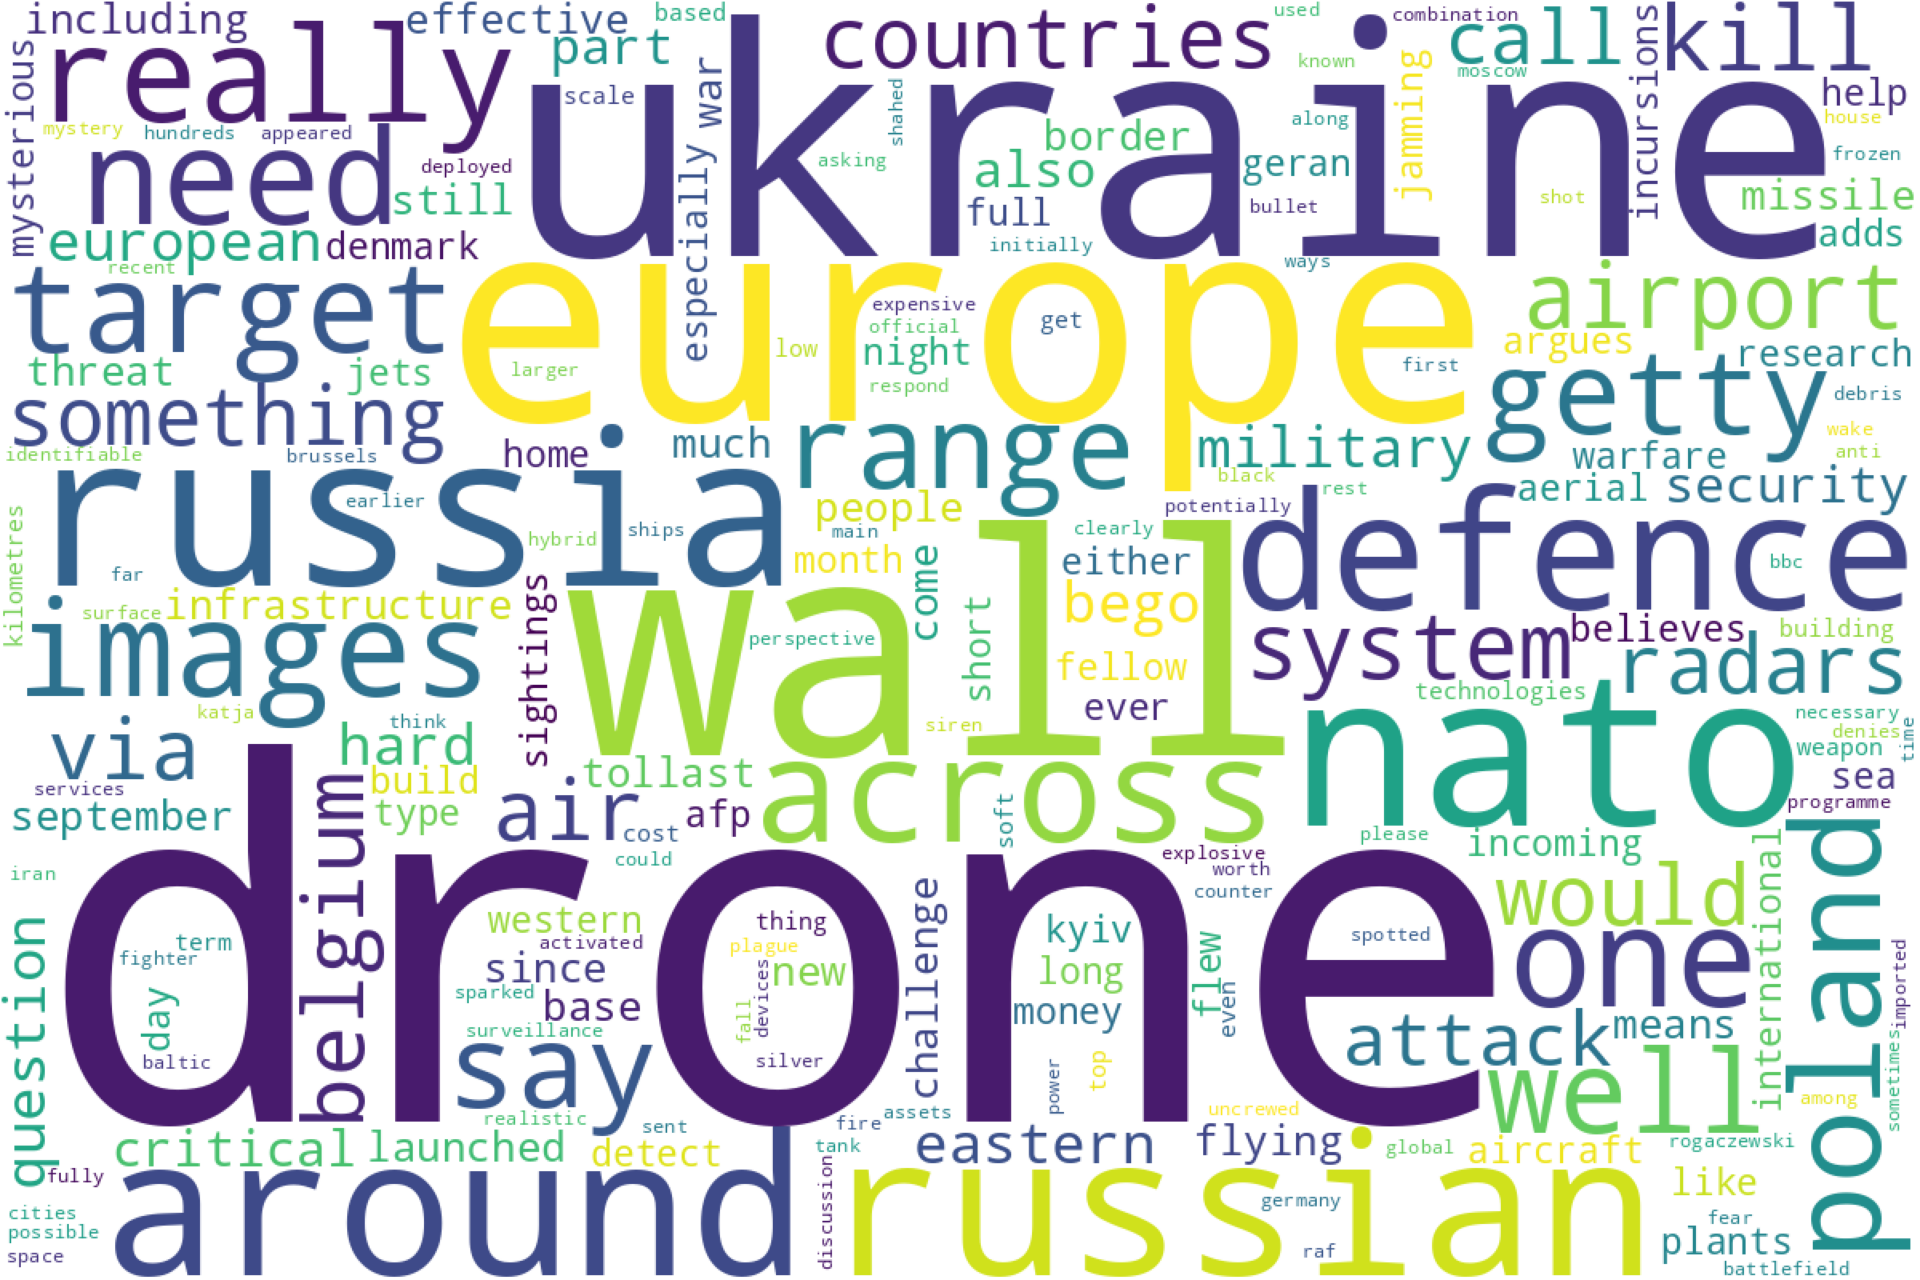

In [14]:
# Show the first wordcloud image inline (if it exists)
from IPython.display import Image, display

if len(df) > 0:
    first_img = os.path.join(OUT_DIR, df.iloc[0]["image"])
    if os.path.exists(first_img):
        display(Image(filename=first_img))
    else:
        print("First image not found on disk:", first_img)
else:
    print("No entries in index.csv yet.")
